<a href="https://colab.research.google.com/github/Amit32624/predicting_solubility/blob/main/prediciting_solubility_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Predicting Solubility of Molecules using PyCaret**

In this project, we are reproducing a research article (by John S. Delaney$^1$) by applying Linear Regression to predict the solubility of molecules (i.e. solubility of drugs is an important physicochemical property in Drug discovery, design and development).

This idea for this notebook was inspired by the excellent blog post by Pat Walters$^2$ where he reproduced the linear regression model with similar degree of performance as that of Delaney. This example is also briefly described in the book Deep Learning for the Life Sciences: Applying Deep Learning to Genomics, Microscopy, Drug Discovery, and More.

## Installing conda and libraries

In [ ]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2021-11-09 08:30:50--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M   118MB/s    in 0.7s    

2021-11-09 08:30:51 (118 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h

## 2. Delaney's solubility dataset¶
The original [Delaney's dataset ](https://pubs.acs.org/doi/10.1021/ci034243x)available as a Supplementary file$^4$. The full paper is entitled ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure.$^1$

## 2.1 Downloading the dataset

In [ ]:
! wget https://pubs.acs.org/doi/suppl/10.1021/ci034243x/suppl_file/ci034243xsi20040112_053635.txt

--2021-11-09 08:32:07--  https://pubs.acs.org/doi/suppl/10.1021/ci034243x/suppl_file/ci034243xsi20040112_053635.txt
Resolving pubs.acs.org (pubs.acs.org)... 104.18.0.20, 104.18.1.20
Connecting to pubs.acs.org (pubs.acs.org)|104.18.0.20|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://pubs.acs.org/doi/suppl/10.1021/ci034243x/suppl_file/ci034243xsi20040112_053635.txt?cookieSet=1 [following]
--2021-11-09 08:32:07--  https://pubs.acs.org/doi/suppl/10.1021/ci034243x/suppl_file/ci034243xsi20040112_053635.txt?cookieSet=1
Reusing existing connection to pubs.acs.org:443.
HTTP request sent, awaiting response... 302 Found
Location: https://pubs.acs.org/doi/suppl/10.1021/ci034243x/suppl_file/ci034243xsi20040112_053635.txt [following]
--2021-11-09 08:32:07--  https://pubs.acs.org/doi/suppl/10.1021/ci034243x/suppl_file/ci034243xsi20040112_053635.txt
Reusing existing connection to pubs.acs.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 60034 (59K

## 2.1 Read in the dataset

In [ ]:
import pandas as pd
df = pd.read_csv("ci034243xsi20040112_053635.txt")
df.head()

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1144 entries, 0 to 1143
Data columns (total 4 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Compound ID                           1144 non-null   object 
 1   measured log(solubility:mol/L)        1144 non-null   float64
 2   ESOL predicted log(solubility:mol/L)  1144 non-null   float64
 3   SMILES                                1144 non-null   object 
dtypes: float64(2), object(2)
memory usage: 35.9+ KB


## 2.3 Examinig the SMILES data

Chemical structures are encoded by a string of text known as SMILES which is an ancronoym for **Smilfied Molecular-Input Line- Entry System**

In [ ]:
df.SMILES

0                                    ClCC(Cl)(Cl)Cl
1                                      CC(Cl)(Cl)Cl
2                                    ClC(Cl)C(Cl)Cl
3                                        ClCC(Cl)Cl
4                               FC(F)(Cl)C(F)(Cl)Cl
                           ...                     
1139                   CNC(=O)C(C)SCCSP(=O)(OC)(OC)
1140          CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C
1141         CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O 
1142    Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O
1143                         CNC(=O)Oc1cc(C)cc(C)c1
Name: SMILES, Length: 1144, dtype: object

In [ ]:
df.SMILES[0]

'ClCC(Cl)(Cl)Cl'

## 2.4 Converting a molecule from the SMILES string to an rdkit object

In [ ]:
from rdkit import Chem
# Convertes the SMILES notation(ASCII FORM) into RDKIT object with the unique object ID
Chem.MolFromSmiles(df.SMILES[0])

In [ ]:
Chem.MolFromSmiles('ClCC(Cl)(Cl)Cl')

## 2.5 Working with RDKIT object

In [ ]:
m = Chem.MolFromSmiles('ClCC(Cl)(Cl)Cl')
m.GetNumAtoms() # get number of atoms, to check how many number of atoms the compound consists of!

6

## 3 Calculating molecular descriptors in rdkit

## 3.1 Convert list of molecules into rdkit object

In [ ]:
from rdkit import Chem

In [ ]:
mol_list =[Chem.MolFromSmiles(element) for element in df.SMILES]

In [ ]:
len(mol_list)

1144

In [ ]:
mol_list[5:10]

## 3.2 Calculating molecular descriptors

To predict LogS(log of aqueous solubility), the study of Delaney makes used of four molecular descriptors:
1. **cLogP** (Octonol-water partition coefficient)
2. **MW** (Molecular weight)
3. **RB** (Number of rotatable bonds)
4. **AP** (Aromatic proportion = Number of aromatic atoms/total number of heavy atoms)

RDKIT helps us to readily calculate the first 3 . As for the AP descripto, we will calculate this by manually computing the ratio of the number of aromatic atoms to the total number of heavy atoms which RDKIT can compute.


## 3.2.1 Calculation ofLogP, MW and RV

In [ ]:
import numpy as np
from rdkit.Chem import Descriptors, Crippen

## 3.2.1.1 Aromatic Proportions
Example on single molecule, how to calculate the aromatic proportion

In [ ]:
mol1 = Chem.MolFromSmiles('CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C')
 #First calculate the aromatic atoms
aromatic_atoms = [mol1.GetAtomWithIdx(i).GetIsAromatic() for i in range(mol1.GetNumAtoms())]
aromatic_atoms # Will return a list with true for Aromatic atoms and vice versa

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 False,
 False]

In [ ]:
def AromaticAtoms(m):
  aromatic_atoms = [m.GetAtomWithIdx(i).GetIsAromatic() for i in range(m.GetNumAtoms())]
  count =[]
  for i in aromatic_atoms:
    if i == True:
      count.append(i)
  sum_count = sum(count)
  return sum_count
AromaticAtoms(mol1)

6

In [ ]:
# Computing the same for the entire dataset
desc_AromaticAtoms = [AromaticAtoms(element) for element in mol_list]
desc_AromaticAtoms

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 0,
 6,
 0,
 0,
 0,
 0,
 6,
 6,
 0,
 6,
 6,
 6,
 6,
 6,
 0,
 6,
 6,
 0,
 0,
 6,
 10,
 6,
 6,
 0,
 6,
 6,
 6,
 6,
 10,
 6,
 0,
 10,
 0,
 14,
 0,
 0,
 14,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 12,
 10,
 14,
 6,
 10,
 10,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 0,
 0,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 0,
 12,
 12,
 12,
 12,
 0,
 0,
 12,
 0,
 0,
 0,
 0,
 0,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 6,
 6,
 12,
 12,
 6,
 0,
 6,
 12,
 6,
 6,
 6,
 6,
 0,
 0,
 10,
 0,
 6,
 12,
 12,
 6,
 12,
 6,
 6,
 6,
 6,
 0,
 0,
 0,
 0,
 6,
 6,
 6,
 12,
 12,
 6,
 10,
 6,
 6,
 6,
 12,
 10,
 14,
 10,
 10,
 0,
 6,
 0,
 0,
 0,
 0,
 6,
 12,
 0,
 10,
 6,
 0,
 6,
 0,
 0,
 6,
 0,
 0,
 0,
 0,
 0,
 10,
 6,
 0,
 0,
 0,
 0,
 10,
 6,
 0,
 6,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 14,
 0,

## 3.2.1.2 Calcuating number of heavy atoms
Here, we use an existing function from rdkit for calculating the numbe of heavy atoms


In [ ]:
# Calculating for a single molecule

mol1 = Chem.MolFromSmiles('CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C')
Descriptors.HeavyAtomCount(mol1)


18

In [ ]:
# Computing for entire dataset
desc_HeavyAtomCount = [Descriptors.HeavyAtomCount(element) for element in mol_list]
desc_HeavyAtomCount[0:4]

[6, 5, 6, 5]

## 3.2.1.3 Computing the Aromatic Proportion(AP) descriptors

In [ ]:
# Computing for a single molecule\
mol1 = Chem.MolFromSmiles('CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C')
AromaticAtoms(mol1)/Descriptors.HeavyAtomCount(mol1)

0.3333333333333333

In [ ]:
# Computing for a entire dataset
desc_AromaticProportion =[AromaticAtoms(element)/Descriptors.HeavyAtomCount(element) for element in mol_list]
desc_AromaticAtoms

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 0,
 6,
 0,
 0,
 0,
 0,
 6,
 6,
 0,
 6,
 6,
 6,
 6,
 6,
 0,
 6,
 6,
 0,
 0,
 6,
 10,
 6,
 6,
 0,
 6,
 6,
 6,
 6,
 10,
 6,
 0,
 10,
 0,
 14,
 0,
 0,
 14,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 12,
 10,
 14,
 6,
 10,
 10,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 0,
 0,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 0,
 12,
 12,
 12,
 12,
 0,
 0,
 12,
 0,
 0,
 0,
 0,
 0,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 6,
 6,
 12,
 12,
 6,
 0,
 6,
 12,
 6,
 6,
 6,
 6,
 0,
 0,
 10,
 0,
 6,
 12,
 12,
 6,
 12,
 6,
 6,
 6,
 6,
 0,
 0,
 0,
 0,
 6,
 6,
 6,
 12,
 12,
 6,
 10,
 6,
 6,
 6,
 12,
 10,
 14,
 10,
 10,
 0,
 6,
 0,
 0,
 0,
 0,
 6,
 12,
 0,
 10,
 6,
 0,
 6,
 0,
 0,
 6,
 0,
 0,
 0,
 0,
 0,
 10,
 6,
 0,
 0,
 0,
 0,
 10,
 6,
 0,
 6,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 14,
 0,

In [ ]:
# Defining the function for calculating Aromatic Proportion
def AromaticProportion(m):
  aromatic_atoms = [m.GetAtomWithIdx(i).GetIsAromatic() for i in range(m.GetNumAtoms())]
  aa_count = []
  for i in aromatic_atoms:
    if i==True:
      aa_count.append(1)
  AromaticAtom = sum(aa_count)
  HeavyAtom = Descriptors.HeavyAtomCount(m)
  AR = AromaticAtom/HeavyAtom
  return AR

In [ ]:

# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def generate(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_MolWt = Descriptors.MolWt(mol)
        desc_NumRotatableBonds = Descriptors.NumRotatableBonds(mol)
        desc_AromaticProportion = AromaticProportion(mol)
           
        row = np.array([desc_MolLogP,
                        desc_MolWt,
                        desc_NumRotatableBonds,
                        desc_AromaticProportion])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MolLogP","MolWt","NumRotatableBonds","AromaticProportion"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

## X matrix

In [ ]:
X = generate(df.SMILES)
X

,MolLogP,MolWt,NumRotatableBonds,AromaticProportion
0,2.59540,167.850,0.0,0.000000
1,2.37650,133.405,0.0,0.000000
2,2.59380,167.850,1.0,0.000000
3,2.02890,133.405,1.0,0.000000
4,2.91890,187.375,1.0,0.000000
...,...,...,...,...
1139,1.98820,287.343,8.0,0.000000
1140,3.42130,286.114,2.0,0.333333
1141,3.60960,308.333,4.0,0.695652
1142,2.56214,354.815,3.0,0.521739


## Y dependent variable

In [ ]:
df.head()

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl


In [ ]:
y = df.iloc[:,1]
y

0      -2.180
1      -2.000
2      -1.740
3      -1.480
4      -3.040
        ...  
1139    1.144
1140   -4.925
1141   -3.893
1142   -3.790
1143   -2.581
Name: measured log(solubility:mol/L), Length: 1144, dtype: float64

## Data splitting

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

## linear regression model


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score

In [ ]:
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# Predicting the X_train
y_pred_train = model.predict(X_train)
print("Coefficients",model.coef_)
print("Intercept",model.intercept_)
print("MSE: %.2f" %mean_squared_error(y_train,y_pred_train))
print('Coefficients of determination (R^2): %.2f' %r2_score(y_train,y_pred_train))

Coefficients [-0.73291769 -0.00653979  0.00118636 -0.42324565]
Intercept 0.22795461726158095
MSE: 1.03
Coefficients of determination (R^2): 0.76


In [ ]:
# Predicting the X_test
y_pred_test = model.predict(X_test)
print("Coefficients",model.coef_)
print("Intercept",model.intercept_)
print("MSE: %.2f" %mean_squared_error(y_test,y_pred_test))
print('Coefficients of determination (R^2): %.2f' %r2_score(y_test,y_pred_test))

Coefficients [-0.73291769 -0.00653979  0.00118636 -0.42324565]
Intercept 0.22795461726158095
MSE: 0.92
Coefficients of determination (R^2): 0.80


In [39]:
X

,MolLogP,MolWt,NumRotatableBonds,AromaticProportion
0,2.59540,167.850,0.0,0.000000
1,2.37650,133.405,0.0,0.000000
2,2.59380,167.850,1.0,0.000000
3,2.02890,133.405,1.0,0.000000
4,2.91890,187.375,1.0,0.000000
...,...,...,...,...
1139,1.98820,287.343,8.0,0.000000
1140,3.42130,286.114,2.0,0.333333
1141,3.60960,308.333,4.0,0.695652
1142,2.56214,354.815,3.0,0.521739


In [ ]:
y = df.iloc[:,1]
y = y.rename("logS")
y

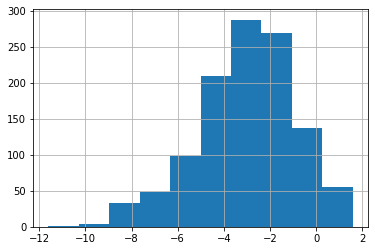

In [42]:
y.hist()

## 4.3 Combining X nad y into same dataframe

In [43]:
dataset = pd.concat([X,y], axis=1)
dataset

,MolLogP,MolWt,NumRotatableBonds,AromaticProportion,logS
0,2.59540,167.850,0.0,0.000000,-2.180
1,2.37650,133.405,0.0,0.000000,-2.000
2,2.59380,167.850,1.0,0.000000,-1.740
3,2.02890,133.405,1.0,0.000000,-1.480
4,2.91890,187.375,1.0,0.000000,-3.040
...,...,...,...,...,...
1139,1.98820,287.343,8.0,0.000000,1.144
1140,3.42130,286.114,2.0,0.333333,-4.925
1141,3.60960,308.333,4.0,0.695652,-3.893
1142,2.56214,354.815,3.0,0.521739,-3.790


In [44]:
dataset.to_csv('delaney_solubility_with_descriptors.csv', index=False)

**Reference**


1.   John S. Delaney. [ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure](https://pubs.acs.org/doi/10.1021/ci034243x).**J. Chem. Inf. Comput. Sci.** 2004, 44, 3, 1000-1005.
2.   Pat Walters. [Predicting Aqueous Solubility - It's Harder Than It Looks](http://practicalcheminformatics.blogspot.com/2018/09/predicting-aqueous-solubility-its.html). **Practical Cheminformatics Blog**
3.   Bharath Ramsundar, Peter Eastman, Patrick Walters, and Vijay Pande. [Deep Learning for the Life S ciences: Applying Deep Learning to Genomics, Microscopy, Drug Discovery, and More,](https://learning.oreilly.com/library/view/deep-learning-for/9781492039822/) **O'Reilly**, 2019.
4.  [Supplementary file ](https://pubs.acs.org/doi/10.1021/ci034243x)from Delaney's ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure.